# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/Src/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/Src/integration")

# add PRA folder to current working path
sys.path.append(parent_directory+"/Demos/AdvectiveBarriers/PRA")

# Import Data

Import the AVISO-data from the file 'Agulhas_AVISO.mat' stored in the folder 'Data'.

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../Data/Aviso/processed_data/Agulhas_AVISO.mat')

U = mat_file['u'][:,:,::7]
V = mat_file['v'][:,:,::7]
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t'][:,::7]

CPU times: user 132 ms, sys: 32 ms, total: 164 ms
Wall time: 167 ms


# Data/Parameters for Dynamical System

In [3]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 32

# time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-Temporal Domain of Dynamical System

In [4]:
%%time
# Initial time (in days)
t0 = 0

# Final time (in days)
tN = 25

# time step-size (in days)
dt = .1

time = np.arange(t0, tN+dt, dt)

# length of time interval (in days)
lenT = tN-t0

# longitudinal and latitudinal boundaries (in degrees)
xmin = -3
xmax = 1
ymin = -32
ymax = -24

# spacing of meshgrid (in degrees)
dx = 0.015
dy = 0.015

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

CPU times: user 837 µs, sys: 995 µs, total: 1.83 ms
Wall time: 980 µs


# Velocity Interpolation

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant. 

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, time, method = "cubic")

CPU times: user 49.3 ms, sys: 15.6 ms, total: 64.8 ms
Wall time: 64.8 ms


# Polar Rotation Angle (PRA)

Next, we compute the PRA over the meshgrid over the given time-interval.
We iterate over all initial conditions and first calculate the gradient of the flow map using an auxiliary grid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid. This parameter is generally chosen to be between $ [\dfrac{1}{10}, \dfrac{1}{100}] $. 

The Polar Rotation Angle (PRA) is then computed from the eigenvectors $ \xi_i\eta_i, \eta_i $ (with i = 1, 2) of the right\left Cauchy-Green strain tensor $ C_{t_0}^{t_N}(\mathbf{x}_0) $:

\begin{equation}
\mathrm{PRA}_{t_0}^{t_N}(\mathbf{x}_0) = \langle \xi_1(\mathbf{x}_0;t_0, t_N), \eta_1(\mathbf{x}_0;t_0, t_N) \rangle = \langle \xi_2(\mathbf{x}_0;t_0, t_N), \eta_2(\mathbf{x}_0;t_0, t_N) \rangle
\end{equation}

As the maximum eigenvalue is less sensitive with respect to numerical errors, it is recommended to use the dominant eigenvectors $ \xi_2, \eta_2 $ in order to compute $ \mathrm{PRA}_{t_0}^{t_N}(\mathbf{x}_0) $.

In [6]:
%%time
# Import gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import package which computes eigenvalues/eigenvectors
from ipynb.fs.defs.eigen import eigen

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import package for computing Polar Rotation Angle (PRA)
from ipynb.fs.defs.PRA import _PRA

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # [1/10, 1/100]
aux_grid = [np.around(aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), 5), np.around(aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0]), 5)]

def parallel_PRA(i):
    
    PRA_parallel = X_domain[0,:].copy()*np.nan
    
    for j in range(X_domain.shape[1]):
        
                # set initial condition
        x = np.array([X_domain[i, j], Y_domain[i, j]])
    
        # compute gradient of flow map from finite differencing 
        gradFmap = gradient_flowmap(time, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta, aux_grid)
        
        # gradFmap has shape (2, 2, len(time)) --> we need gradient of flow map from t0 to tN
        gradFmap_t0_tN = gradFmap[:,:,-1]
        
        # compute PRA
        PRA_parallel[j] = _PRA(gradFmap_t0_tN)
        
    return PRA_parallel

PRA = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_PRA)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/535 [00:00<?, ?it/s]

CPU times: user 8.94 s, sys: 1.35 s, total: 10.3 s
Wall time: 13min 13s


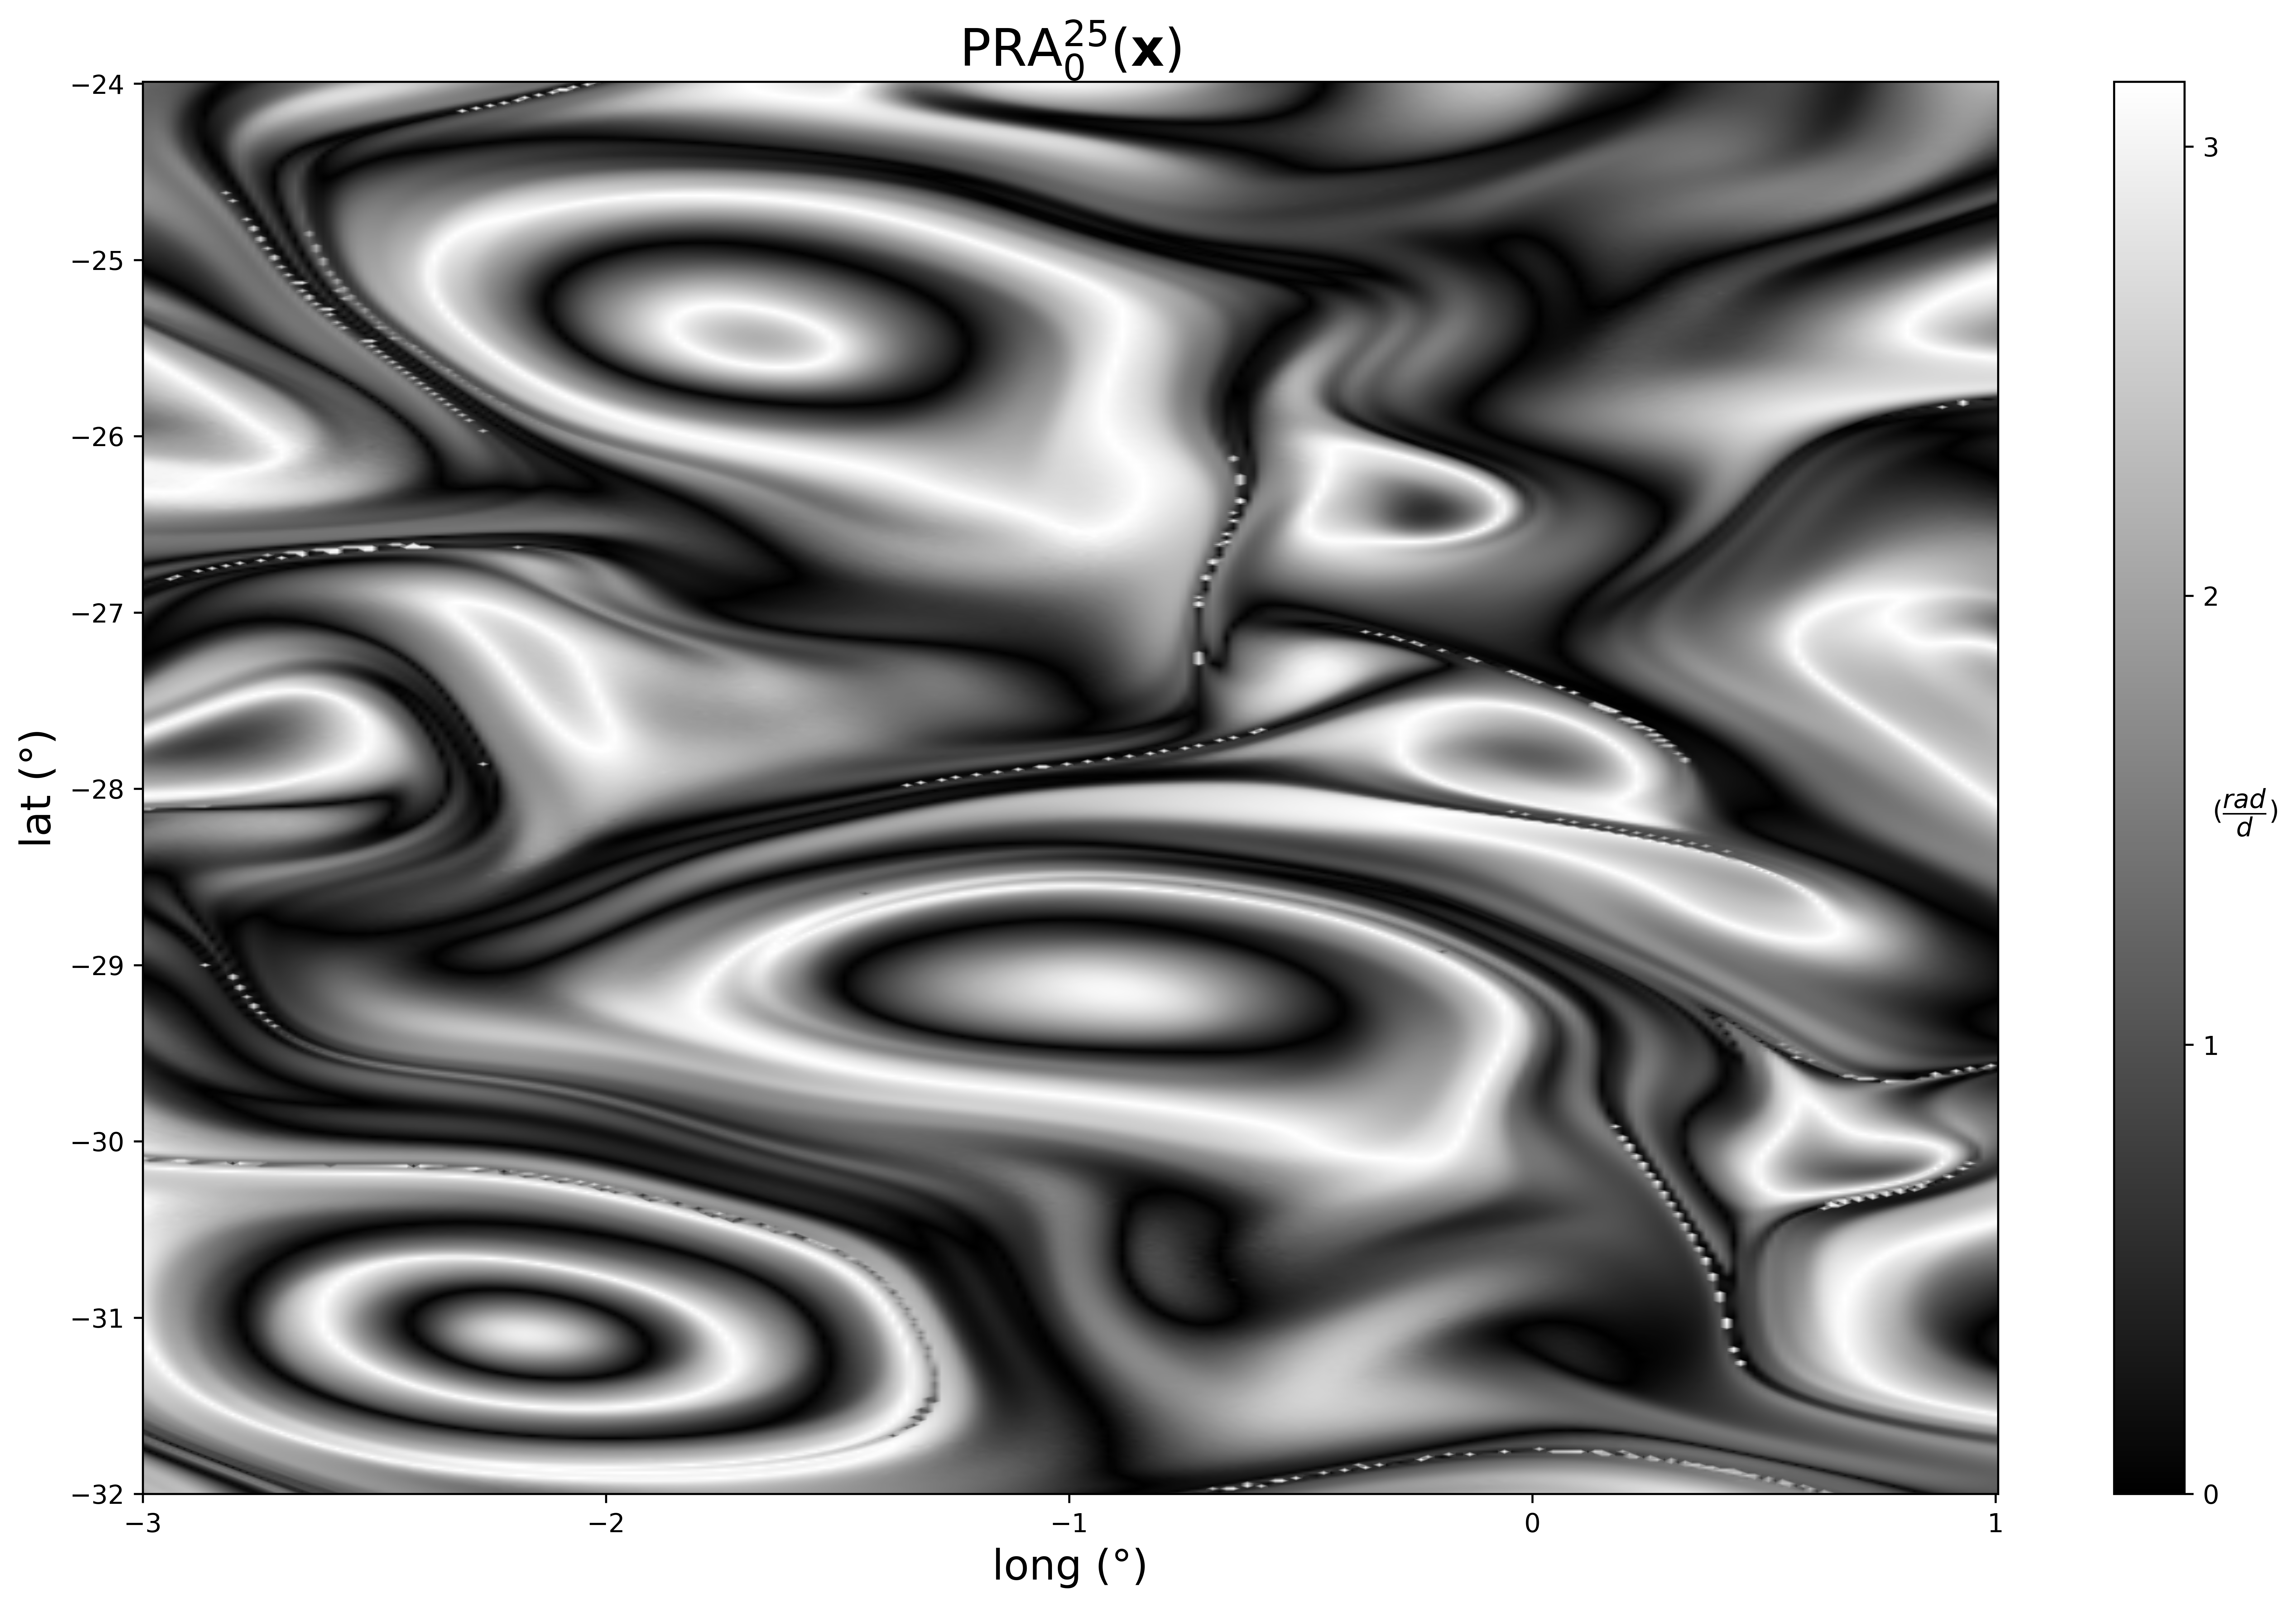

In [7]:
######################## PLOT RESULTS ########################

# Import plotting libraries
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(16, 10), dpi = 600)
ax = plt.axes()

# Contourplot of TSE over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, PRA, cmap = "gist_gray", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 16)
ax.set_ylabel("lat (°)", fontsize = 16)

# Ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain), 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain), 1))

# Colorbar
cbar = fig.colorbar(cax, ticks = [0, 1, 2, 3])
cbar.ax.set_ylabel(r'$(\dfrac{rad}{d})$', rotation = 0, labelpad = 10, fontsize = 10)

# Title
ax.set_title(r'$ \mathrm{PRA}$'+f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$'+r'$(\mathbf{x})$', fontsize = 20)

plt.show()